Sort people into leagues for curling
KL 8/30/2016; updated 9/11/2016

In [256]:
#tends to have <4 more people on the list not getting all the leagues they want

In [257]:
%reset -f

In [258]:
setSeed = False

In [259]:
#set the random seed...if a number...will be able to recreate the random numbers
if setSeed == True:
    SEED = 42
elif setSeed == False:
    SEED = None

In [260]:
import pandas as pd
import numpy as np
import random
import math
import csv
import os.path

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 

%matplotlib inline

Define some functions up top

In [261]:
def addOne(leagueDict,oneLeague,oneName):
    if len(leagueDict[oneLeague])==0: #nothing there yet
        leagueDict[oneLeague] = oneName
    else:     #need to append
        leagueDict[oneLeague] = leagueDict[oneLeague].append(oneName)
    return leagueDict

In [262]:
def addManager(leagueDictionary,r,manager): #here r is the index in...
    useRow = r.index[0]
    oneName = regSorted.loc[useRow,['lastname', 'firstname']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output
    leagueDictionary[manager] = oneName
    regSorted.loc[useRow,manager]=np.nan
    regTracking.loc[useRow,manager]='yes'
    return leagueDictionary

In [263]:
def fileOut():
    regTracking.to_csv('outTracking.csv')

In [264]:
def setTracking(answer,regTracking,regSorted,idxIn,leagueIn):
    regTracking.loc[idxIn,leagueIn] = answer
    regSorted.loc[idxIn,leagueIn] = np.nan
    return regTracking, regSorted

In [265]:
def doStuff(iteration,idx,regTracking,regSorted,leagueDict_open,trackIssues):
    tAns = iterAnswers.loc[iterAnswers['iteration']==iteration]
    
    oneName = regTracking.loc[idx,['lastname', 'firstname']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output 
    #get their next choice
    newPriority = regSorted.loc[idx,openLeagues].dropna().min()
    if math.isnan(newPriority) == False: #have another league listed
        league2 = regSorted.loc[idx,openLeagues].dropna().idxmin() #returns name of league
        #first need to check if the league has space
        if len(leagueDict_open[league2]) < (nLimit.loc[league2,'nLimit']):
            leagueDict_open = addOne(leagueDict_open,league2,oneName)
            regTracking, regSorted = setTracking('yes',regTracking,regSorted,idx,league2)               
        else: #no space in league
            trackIssues = addOne(trackIssues,tAns.sortingIssue.loc[tAns.sortingIssue.index[0]],oneName) #seems crazy...
            #set their first choice to 'no' and move onto second choices
            regTracking, regSorted = setTracking(tAns.noAnswer.loc[tAns.noAnswer.index[0]],regTracking,regSorted,idx,league2)                               

    elif math.isnan(newPriority):
        trackIssues = addOne(trackIssues,tAns.choiceIssue.loc[tAns.choiceIssue.index[0]],oneName)

    return regTracking, regSorted, leagueDict_open, trackIssues

Read in the data

In [266]:
#updated 8/30/2016 to use file from website
fName = 'BackupList_Registrations.csv' 
importInfo=pd.read_csv(fName)

In [267]:
#shuffle the information from the website site to match the format in the rest of this file
openLeagues = ['Sunday Night', 'Monday 4PM', 'Monday Night',
               'Tuesday 4PM','Wednesday 4PM','Thursday 4PM'] #updated to match the priority list
otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']
priorities = ['League_Pri_1','League_Pri_2','League_Pri_3','League_Pri_4','League_Pri_5','League_Pri_6']

regInfo = importInfo.loc[:,(['firstname','lastname','email','League_Number_Open'] + otherLeagues)]

for item in openLeagues:
    regInfo[item] = np.nan

nPeople = len(regInfo.index)
for idx in range(0,nPeople):
    for idxP in enumerate(priorities):
        #remember: enumerate will allow idxP[0] is the number, while idxP[1] is the value
        getOne = importInfo.loc[idx,idxP[1]]
        if getOne != 'None':
            regInfo.loc[idx,getOne] = idxP[0] + 1  #want 1,2,3 and not python zero index

In [268]:
#first, how many random numbers so I need?
nPeople = len(regInfo.index)
np.random.seed(SEED)
regInfo['randomNumCol'] = np.random.choice(range(nPeople), nPeople,replace = False)
##so now, moving back to the list of people, sort the list by the random number
#...still need to randomize people bc might have case where I can't grant first choice
regSorted = regInfo.sort_values(by = 'randomNumCol', ascending=True)
regSorted = regSorted.set_index(['randomNumCol'])

#copy so I can have an output tracking what was done
regTracking = regSorted.copy(deep=True)

setup the places to store the output

In [269]:
# random.seed(SEED)
# randLeagues = list(openLeagues) #make a copy of the list
# random.shuffle(randLeagues) #does this in place, so don't make a new variable
# randLeagues

In [270]:
#in this version, set the order I run the leagues manually

In [271]:
#outcome is 23: randLeagues = ['Thursday 4PM','Monday 4PM','Wednesday 4PM','Tuesday 4PM','Monday Night','Sunday Night']
#outcome is 21:
#randLeagues = ['Tuesday 4PM', 'Monday Night', 'Sunday Night', 'Wednesday 4PM', 'Monday 4PM', 'Thursday 4PM']

randLeagues = ['Tuesday 4PM', 'Monday Night', 'Sunday Night', 'Wednesday 4PM', 'Monday 4PM', 'Thursday 4PM']

#outcome is 21:
# randLeagues = 
# ['Tuesday 4PM',
#  'Monday Night',
#  'Wednesday 4PM',
#  'Monday 4PM',
#  'Thursday 4PM',
#  'Sunday Night']

In [272]:
#want a way to quantify the most popular leagues...go back to regInfo
countFirst = {}
for name in openLeagues:
    #countFirst[name] = pd.DataFrame()
    countFirst[name] = len(regInfo.loc[regInfo[name]==1])

countFirst

{'Monday 4PM': 25,
 'Monday Night': 35,
 'Sunday Night': 28,
 'Thursday 4PM': 28,
 'Tuesday 4PM': 19,
 'Wednesday 4PM': 15}

In [273]:
#setup the dictionary to hold the people information (start with openLeagues only)
forDictionary = openLeagues
#forDictionary.extend(otherLeagues)
leagueDict_open = {}
for name in forDictionary:
    leagueDict_open[name] = pd.DataFrame()

In [274]:
# put the manager information into a loop bc need to check later for them
names = [['Bill','Fragaszy'],['Peter','Brown'],['Diane', 'DiMassa'],['Kenny', 'Thomson'],
        ['Katie', 'Murphy'],['Bill', 'Gallagher']]
leagues = ['Sunday Night','Monday 4PM','Monday Night','Tuesday 4PM','Wednesday 4PM','Thursday 4PM']

managers = pd.DataFrame(names,columns = ['firstname','lastname'],index = [leagues])

if True:
    #put the league managers into their league and set their the choice for that league to NaN
    for oL,item in managers.iterrows():
        r = regSorted.loc[(regSorted['lastname']==item.lastname) & (regSorted['firstname']==item.firstname)]
        leagueDict_open = addManager(leagueDict_open,r,oL)

In [275]:
#set the limit for each league:
sevenTeams = 28 #change to 28 (remember league manager already in here)
eightTeams = 32
fourteenTeams = 56

d = {'Sunday Night': eightTeams,
     'Monday 4PM': sevenTeams,
     'Monday Night': fourteenTeams,
     'Tuesday 4PM': sevenTeams,
     'Wednesday 4PM': sevenTeams,
     'Thursday 4PM': sevenTeams,}

nLimit = pd.DataFrame({'nLimit' : d})
del d

In [276]:
pd.options.mode.chained_assignment = None  # default='warn'

In [277]:
#go through a league and grant first choice for leagues...don't worry about league #2 yet
for oneLeague in randLeagues:
    subset = regSorted.loc[regSorted[oneLeague]==1]
    subset.reset_index(inplace = True)
    nPeople = len(subset.index)
    
    #what is the limit for this league?
    oneLimit = nLimit.loc[oneLeague][0]
    
    for idx in range(0,nPeople):
        getIdx = subset.loc[idx,'randomNumCol'] #use getIdx to go back into full index
        oneName = subset.loc[idx,['lastname', 'firstname']] #remember, idx is into subset
        oneName = oneName.to_frame().transpose() #need this format to make nice output 
        
        #ACK...don't forget that idx will start at zero and league manager is in here
        if idx  <= (oneLimit - 2):           
            leagueDict_open = addOne(leagueDict_open,oneLeague,oneName)   
            regTracking, regSorted = setTracking('yes',regTracking,regSorted,getIdx,oneLeague)
        elif idx  > (oneLimit - 2):
            trackIssues = addOne(trackIssues, 'round1_notInFirst',oneName)            
            regTracking, regSorted = setTracking('no1',regTracking,regSorted,getIdx,oneLeague)

In [278]:
#OK...regTracking now has a 'no1' for those people who did not get their first choice...use that to
#put those people into their second choice league
for oneLeague in randLeagues:    
    #how many spaces are left in this league? Use to figure out how many to add
    nRemaining = nLimit.loc[oneLeague][0] - len(leagueDict_open[oneLeague])  
    print oneLeague, nRemaining

Tuesday 4PM 9
Monday Night 21
Sunday Night 4
Wednesday 4PM 12
Monday 4PM 3
Thursday 4PM 0


In [279]:
choiceIssue = ['noSecondChoice','noAdditionalChoice','noAdditionalChoice','noAdditionalChoice']
sortingIssue = ['round1_noRoom','round2_noRoom','round3_noRoom','round4_noRoom']

issueNames = choiceIssue + sortingIssue
#setup the dictionary to hold the issues
trackIssues = {}
for name in issueNames:
    trackIssues[name] = pd.DataFrame()

In [280]:
iterAnswers = pd.DataFrame(
    {'iteration': ['first','second','third','fourth'],
     'choiceIssue': choiceIssue,
    'sortingIssue': sortingIssue,
    'noAnswer':['no1','no2','no3','no4']})

In [281]:
#go see if we can grant 2nd choices for the first round
for idx in range(0,len(regTracking)):  
    doSomething = []
    r = regTracking.loc[idx,openLeagues]
    for item in range(0,len(r)):
        if r[item] == 'no1':
            doSomething = True

    if doSomething:
        #def working(iteration,idx,regTracking,regSorted,leagueDict_open,trackIssues):
        regTracking,regSorted, leagueDict_open,trackIssues = doStuff('first',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [282]:
#go see if we need to use 3rd choices for the first round
for idx in range(0,len(regTracking)):  
    doSomething = 0
    r = regTracking.loc[idx,openLeagues]
    for item in range(0,len(r)):
        if r[item] == 'no1': #need two 'no' responses to doSomething
             doSomething = doSomething+1

    if doSomething > 1:
        regTracking,regSorted, leagueDict_open,trackIssues = doStuff('first',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [283]:
if len(trackIssues['round1_noRoom'])==0:
    #no longer trying to grant a first choice
    print 'yes'
else:
    print 'should have kept going'

yes


In [284]:
#now start working on second choices
for idx in reversed(range(0,len(regTracking))):
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None' : 
        if int(nLeagues) > 1:  
            #print idx
            regTracking,regSorted,leagueDict_open,trackIssues = doStuff('second',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [285]:
#keep trying to get people their second league
for idx in reversed(range(0,len(regTracking))):  
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None':
        doSomething = 0
        r = regTracking.loc[idx,openLeagues]
        for item in range(0,len(r)):
            if r[item] == 'no2': #need two 'no' responses to doSomething
                 doSomething = doSomething+1
       
        if (doSomething > 0) & (int(nLeagues) > 1):
            regTracking,regSorted, leagueDict_open,trackIssues = doStuff('second',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [286]:
#keep trying to get people their second league
for idx in reversed(range(0,len(regTracking))):  
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None':
        doSomething = 0
        r = regTracking.loc[idx,openLeagues]
        for item in range(0,len(r)):
            if r[item] == 'no2': #need two 'no' responses to doSomething
                 doSomething = doSomething+1
       
        if (doSomething > 1) & (int(nLeagues) > 1):
            regTracking,regSorted, leagueDict_open,trackIssues = doStuff('second',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [287]:
#keep trying to get people their second league
for idx in reversed(range(0,len(regTracking))):  
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None':
        doSomething = 0
        r = regTracking.loc[idx,openLeagues]
        for item in range(0,len(r)):
            if r[item] == 'no2': #need two 'no' responses to doSomething
                 doSomething = doSomething+1
       
        if (doSomething > 1) & (int(nLeagues) > 1):
            regTracking,regSorted, leagueDict_open,trackIssues = doStuff('second',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [288]:
#how many spaces are left in this league? Use to figure out how many to add
for oneLeague in randLeagues:    
    nRemaining = nLimit.loc[oneLeague][0] - len(leagueDict_open[oneLeague])  
    print oneLeague, nRemaining

Tuesday 4PM 0
Monday Night 16
Sunday Night 0
Wednesday 4PM 0
Monday 4PM 0
Thursday 4PM 0


##end of second round, what about people who want to curl 3x?

In [289]:
#now start trying to grant people who want a third league
for idx in range(0,len(regTracking)):
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None' : 
        if int(nLeagues) > 2:   
            regTracking,regSorted, leagueDict_open,trackIssues = doStuff('third',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [290]:
#keep trying to grant people who want a third league
for idx in range(0,len(regTracking)):
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None' : 
        if int(nLeagues) > 2:  
            regTracking,regSorted, leagueDict_open,trackIssues = doStuff('third',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [291]:
#keep trying to grant people who want a third league
for idx in range(0,len(regTracking)):
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None' : 
        if int(nLeagues) > 2:   
            regTracking,regSorted, leagueDict_open,trackIssues = doStuff('third',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [292]:
#keep trying to grant people who want a third league
for idx in reversed(range(0,len(regTracking))):
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None' : 
        if int(nLeagues) > 2:   
            regTracking,regSorted, leagueDict_open,trackIssues = doStuff('third',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [293]:
#...and for the one person who wants to curl in 4 leagues:
for idx in reversed(range(0,len(regTracking))):
    nLeagues = regTracking.loc[idx,'League_Number_Open']
    if nLeagues != 'None' : 
        if int(nLeagues) > 3:   
            regTracking,regSorted, leagueDict_open,trackIssues = doStuff('fourth',idx,regTracking,regSorted,leagueDict_open,trackIssues)

In [294]:
#make a new dictionary for other leagues...concat with openLeagues when done
# do doubles and competitive league by hand...
otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']

leagueDict_other = {}
for name in otherLeagues:
    leagueDict_other[name] = pd.DataFrame()

In [295]:
if True:
    #put league managers in for other
    manager = 'League_4_Men'
    r = regSorted.loc[(regSorted['lastname']=='Pijanowski') & (regSorted['firstname']=='Brian')]
    leagueDict_other = addManager(leagueDict_other,r,manager)

    manager = 'League_7_Ladies'
    r = regSorted.loc[(regSorted['lastname']=='Galligan') & (regSorted['firstname']=='Natalie')]
    leagueDict_other = addManager(leagueDict_other,r,manager)

    manager = 'League_Scrod'
    r = regSorted.loc[(regSorted['lastname']=='Pilotte') & (regSorted['firstname']=='Courtney Lee')]
    leagueDict_other = addManager(leagueDict_other,r,manager)

In [296]:
#only have to go through once
for idx in range(0,len(regSorted)):
    for oL in otherLeagues:    
        oneName = regSorted.loc[idx,['lastname', 'firstname']] 
        oneName = oneName.to_frame().transpose() #need this format to make nice output
        if regSorted.loc[idx,oL]=='Yes': #careful with trailing spaces
            leagueDict_other = addOne(leagueDict_other,oL,oneName)
            #now that I have added the person to a league, change their priority to NaN
            regTracking.loc[idx,oL] = 'yes'
            regSorted.loc[idx,oL] = np.nan

In [297]:
#combine the two dictionaries
leagueDict_all = leagueDict_open.copy()
leagueDict_all.update(leagueDict_other)

#combine the list of names
allLeagues = list(openLeagues)
allLeagues.extend(otherLeagues)

In [298]:
#export the results to a series of CSV files (CAREFUL...will delete existing files)
for fn in allLeagues:
    fName = '%s.csv' % fn
    #check if the file exists...delete if it does
    if os.path.isfile(fName):
        os.remove(fName)
        
    leagueDict_all[fn].to_csv(fName)

,nPeople
Sunday Night,32.0
Monday 4PM,28.0
Monday Night,42.0
Tuesday 4PM,28.0
Wednesday 4PM,28.0
Thursday 4PM,28.0


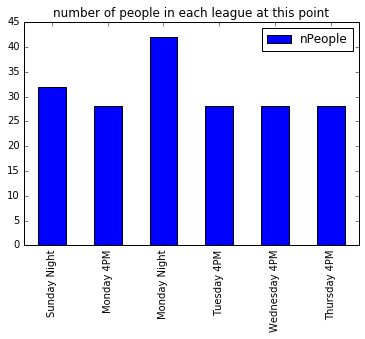

In [299]:
#do some plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = openLeagues, columns=['nPeople'])
for name in openLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_open[name])
    
gather.plot(kind = 'bar',title='number of people in each league at this point')
gather

In [300]:
for problem in issueNames:
    print problem, ': ', len(trackIssues[problem]), ' people in this category'
    
randLeagues

noSecondChoice :  0  people in this category
noAdditionalChoice :  51  people in this category
noAdditionalChoice :  51  people in this category
noAdditionalChoice :  51  people in this category
round1_noRoom :  0  people in this category
round2_noRoom :  25  people in this category
round3_noRoom :  19  people in this category
round4_noRoom :  0  people in this category


['Tuesday 4PM',
 'Monday Night',
 'Sunday Night',
 'Wednesday 4PM',
 'Monday 4PM',
 'Thursday 4PM']

In [301]:
#gather up the number of people with # 'yes' < League_Number_Open
outcome = regTracking.copy(deep = True)

for idx in range(0,len(regTracking)):   
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        r = regTracking.loc[idx,openLeagues]
        nLeagues = 0
        for item in range(0,len(r)):
            if r[item] == 'yes':
                nLeagues = nLeagues + 1
        if nLeagues == int(regTracking.loc[idx,'League_Number_Open']):
            #delete from the dataframe
            outcome.drop(idx,inplace = True)
    else: #did not want open leagues, drop them too
        outcome.drop(idx,inplace = True)
        
outcome.sort_values(by = 'League_Number_Open', inplace = True)

In [302]:
len(outcome)

21

In [303]:
outcome.to_csv('exportOutcome.csv')
regTracking.to_csv('exportTracking.csv')
regSorted.to_csv('exportSorted.csv')
regInfo.to_csv('exportInfo.csv')

In [304]:
#run multiple times and see the variability

In [305]:
for problem in issueNames:
    print problem, ': ', len(trackIssues[problem]), ' people in this category'
    
randLeagues

noSecondChoice :  0  people in this category
noAdditionalChoice :  51  people in this category
noAdditionalChoice :  51  people in this category
noAdditionalChoice :  51  people in this category
round1_noRoom :  0  people in this category
round2_noRoom :  25  people in this category
round3_noRoom :  19  people in this category
round4_noRoom :  0  people in this category


['Tuesday 4PM',
 'Monday Night',
 'Sunday Night',
 'Wednesday 4PM',
 'Monday 4PM',
 'Thursday 4PM']

In [306]:
for problem in issueNames:
    print problem, ': ', len(trackIssues[problem]), ' people in this category'
    
randLeagues

noSecondChoice :  0  people in this category
noAdditionalChoice :  51  people in this category
noAdditionalChoice :  51  people in this category
noAdditionalChoice :  51  people in this category
round1_noRoom :  0  people in this category
round2_noRoom :  25  people in this category
round3_noRoom :  19  people in this category
round4_noRoom :  0  people in this category


['Tuesday 4PM',
 'Monday Night',
 'Sunday Night',
 'Wednesday 4PM',
 'Monday 4PM',
 'Thursday 4PM']

In [307]:
for problem in issueNames:
    print problem, ': ', len(trackIssues[problem]), ' people in this category'
    
randLeagues

noSecondChoice :  0  people in this category
noAdditionalChoice :  51  people in this category
noAdditionalChoice :  51  people in this category
noAdditionalChoice :  51  people in this category
round1_noRoom :  0  people in this category
round2_noRoom :  25  people in this category
round3_noRoom :  19  people in this category
round4_noRoom :  0  people in this category


['Tuesday 4PM',
 'Monday Night',
 'Sunday Night',
 'Wednesday 4PM',
 'Monday 4PM',
 'Thursday 4PM']